<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Experiments:" data-toc-modified-id="Experiments:-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Experiments:</a></span><ul class="toc-item"><li><span><a href="#Experiment-using-PLS:" data-toc-modified-id="Experiment-using-PLS:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Experiment using PLS:</a></span></li><li><span><a href="#Experiment-using-HSIC:" data-toc-modified-id="Experiment-using-HSIC:-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Experiment using HSIC:</a></span></li></ul></li><li><span><a href="#Twitter-Dataset:" data-toc-modified-id="Twitter-Dataset:-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Twitter Dataset:</a></span><ul class="toc-item"><li><span><a href="#Cleaning-of-Data:" data-toc-modified-id="Cleaning-of-Data:-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Cleaning of Data:</a></span></li></ul></li></ul></div>

In [1]:
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd
import sklearn
import sklearn.metrics
import sklearn.neighbors
import sklearn.cross_decomposition

In [12]:
# HSIC CODE:
import autograd.numpy
from pymanopt.manifolds import Stiefel
from pymanopt import Problem
from pymanopt.solvers import SteepestDescent

from scipy.spatial.distance import pdist

global XHSIC, YHSIC, sgx, sgy

def median_distance(X):
    return np.mean(pdist(X))


def gaussian_rbf_gram(MAT1, MAT2, sigma_val):
    """ Computes Gaussian RBF Gram matrix kernel using autograd.numpy:

            k(X, Y) = - exp[||X - Y||^2 / (2sigma^2)]

    REFERENCE: https://github.com/amber0309/HSIC

    Parameters
    ----------
    MAT1 : np.ndarray | Matrix X in the formula.
    MAT2 : np.ndarray | Matrix Y in the formula.
    sigma_val : float | Value for regularising coeff.
    Returns
    -------
    np.ndarray | Gram matrix
        Description of returned object.
    """
    G = autograd.numpy.sum(MAT1*MAT1, 1).reshape(MAT1.shape[0],1)
    H = autograd.numpy.sum(MAT2*MAT2, 1).reshape(MAT2.shape[0],1)

    Q = autograd.numpy.tile(G, (1, MAT2.shape[0]))
    R = autograd.numpy.tile(H.T, (MAT1.shape[0], 1))

    H = Q + R - 2* autograd.numpy.dot(MAT1, MAT2.T)
    return autograd.numpy.exp(-H/2/(sigma_val**2))


def HSIC_gRBF(XMAT, YMAT, sgx, sgy):
    """ Computes the Hilbert-Schmidt Independence Criterion between matrices
        X and Y:

            HSIC = 1/(N - 1)^2 * trace(Gx H Gy H)

    Parameters
    ----------
    XMAT : np.ndarray | Matrix X in the formula.
    YMAT : np.ndarray | Matrix Y in the formula.
    sgx : float | sigma_x parameter in gaussian RBF kernel
    sgy : float | sigma_y parameter in gaussian RBF kernel

    Returns
    -------
    float | value of HSIC calculated
    """
    N, p = XMAT.shape
    HMAT = autograd.numpy.eye(N) - autograd.numpy.ones((N, N))

    Gx = gaussian_rbf_gram(XMAT, XMAT, sgx)

    if len(YMAT.shape) == 2:
        Gy = gaussian_rbf_gram(YMAT, YMAT, sgy)
    elif len(YMAT.shape) == 1:  # Just a vector, convert to column matrix
        Gy = gaussian_rbf_gram(YMAT[:, None], YMAT[:, None], sgy)
    else:
        raise Exception("Error with Y Dimensions")
    return autograd.numpy.trace(Gx @ HMAT @ Gy @ HMAT)


def hsic_cost_function(P):
    """ Helper function for Pymanopt optimisation."""
    global XHSIC, YHSIC, sgx, sgy
    return - HSIC_gRBF(XHSIC @ P, YHSIC, sgx, sgy)

# Experiments:

Synthetic data accodring to section 4.1 in the report:

In [3]:
def generating_data(mu):
    X1 = np.random.normal(0, 1, size=(1000, 20))  # 20-dimensional 'normal' points
    X2 = np.random.normal(0, 1, size=(40, 20))
    X2[:, 0] = np.random.normal(mu, np.sqrt(0.1), size=40)
    X2[:, 1] = np.random.normal(mu, np.sqrt(0.1), size=40)

    Y1 = np.sqrt(np.sum(X1**2, axis=1))
    Y2 = np.sqrt(np.sum(X2**2, axis=1))
    return X1, X2, Y1, Y2

In [14]:
def pls_iteration(num_dims, mu):
    X1, X2, Y1, Y2 = generating_data(mu)

    # Splitting into training and testing data:
    shuffle_id1 = np.random.permutation(np.arange(1000))
    shuffle_id2 = np.random.permutation(np.arange(40))

    Xtrain = np.concatenate([X1[shuffle_id1[:800]], X2[shuffle_id2[:32]]])
    Ytrain = np.concatenate([Y1[shuffle_id1[:800]], Y2[shuffle_id2[:32]]])

    Xtest = np.concatenate([X1[shuffle_id1[800:]], X2[shuffle_id2[32:]]])
    Ytest = np.concatenate([Y1[shuffle_id1[800:]], Y2[shuffle_id2[32:]]])    

    # Train PLS on this:
    PLS = sklearn.cross_decomposition.PLSRegression(n_components=num_dims)
    PLS.fit(Xtrain, Ytrain)

    # Transform test data:
    Xtest_PLS = PLS.transform(Xtest)

    # Computing KNN on this data:
    KNN = sklearn.neighbors.NearestNeighbors(n_neighbors=10)
    KNN.fit(Xtest_PLS)

    # Getting Distances to nearest neighbors:
    neigh_dists, neigh_inds = KNN.kneighbors(Xtest_PLS, n_neighbors=10)    
    ave_neigh_dists = np.mean(neigh_dists, axis=1)
    mean_ave_neigh_dists = np.mean(ave_neigh_dists)
    std_ave_neigh_dists = np.std(ave_neigh_dists)

    # Test:
    cutoff_point = 3*std_ave_neigh_dists
    normal_points = np.where(ave_neigh_dists <= cutoff_point)[0]
    anomalies = np.where(ave_neigh_dists > cutoff_point)[0]

    # Computing accuracy:
    Ytrue = np.zeros(208)
    Ytrue[-8:] = 1  # Last 8 points are from second distribution

    Ypreds = np.zeros(208)
    Ypreds[anomalies] = 1

    accuracy_score = sklearn.metrics.accuracy_score(Ypreds[-8:], Ytrue[-8:])
    return accuracy_score, Xtest_PLS, normal_points, anomalies


def hsic_iteration(num_dims, mu):
    global XHSIC, YHSIC, sgx, sgy
    X1, X2, Y1, Y2 = generating_data(mu)

    # Splitting into training and testing data:
    shuffle_id1 = np.random.permutation(np.arange(1000))
    shuffle_id2 = np.random.permutation(np.arange(40))

    Xtrain = np.concatenate([X1[shuffle_id1[:800]], X2[shuffle_id2[:32]]])
    Ytrain = np.concatenate([Y1[shuffle_id1[:800]], Y2[shuffle_id2[:32]]])

    Xtest = np.concatenate([X1[shuffle_id1[800:]], X2[shuffle_id2[32:]]])
    Ytest = np.concatenate([Y1[shuffle_id1[800:]], Y2[shuffle_id2[32:]]])
    
    # Train HSIC method on training data:
    # Finding optimal sgx, sgy using gKDR method of median distance:
    sgx = median_distance(Xtrain)
    sgy = median_distance(Ytrain[:, None])
    
    XHSIC = Xtrain.copy()
    YHSIC = Ytrain.copy()
    
    # Perform manifold learning:
    manifold = Stiefel(20, num_dims)
    problem = Problem(manifold=manifold, cost=hsic_cost_function)
    solver = SteepestDescent()
    Popt = solver.solve(problem)
    
    Xtest_HSIC = Xtest @ Popt
    
    # Computing KNN on this data:
    KNN = sklearn.neighbors.NearestNeighbors(n_neighbors=10)
    KNN.fit(Xtest_HSIC)

    # Getting Distances to nearest neighbors:
    neigh_dists, neigh_inds = KNN.kneighbors(Xtest_HSIC, n_neighbors=10)    
    ave_neigh_dists = np.mean(neigh_dists, axis=1)
    mean_ave_neigh_dists = np.mean(ave_neigh_dists)
    std_ave_neigh_dists = np.std(ave_neigh_dists)
    
    ave_neigh_dists = np.mean(neigh_dists, axis=1)
    mean_ave_neigh_dists = np.mean(ave_neigh_dists)
    std_ave_neigh_dists = np.std(ave_neigh_dists)

    # Test:
    cutoff_point = 3*std_ave_neigh_dists
    normal_points = np.where(ave_neigh_dists <= cutoff_point)[0]
    anomalies = np.where(ave_neigh_dists > cutoff_point)[0]

    # Computing accuracy:
    Ytrue = np.zeros(208)
    Ytrue[-8:] = 1  # Last 8 points are from second distribution

    Ypreds = np.zeros(208)
    Ypreds[anomalies] = 1

    accuracy_score = sklearn.metrics.accuracy_score(Ypreds[-8:], Ytrue[-8:])
    return accuracy_score, Xtest_HSIC, normal_points, anomalies

## Experiment using PLS:

In [19]:
mu_array = np.array([5, 6])


# np.linspace(0, 4, 100)

acc_2dims_array = np.zeros(mu_array.shape)
acc_3dims_array = np.zeros(mu_array.shape)

for k in range(100):
    for i, mu in enumerate(mu_array):
        acc_2dims = pls_iteration(2, mu)[0]
        acc_3dims = pls_iteration(3, mu)[0]
    
        acc_2dims_array[i] += acc_2dims
        acc_3dims_array[i] += acc_3dims
        
acc_2dims_array /= 100
acc_3dims_array /= 100

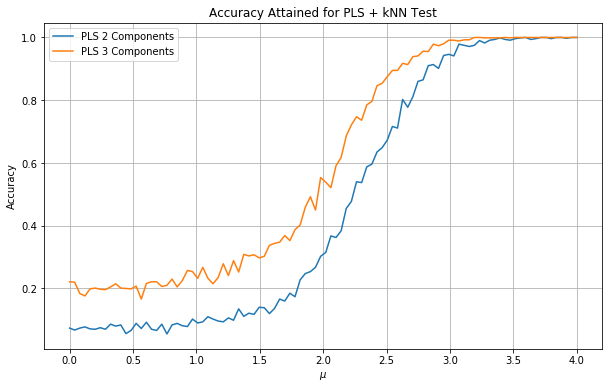

In [223]:
plt.figure(figsize=(10, 6))
plt.plot(mu_array, acc_2dims_array, label="PLS 2 Components")
plt.plot(mu_array, acc_3dims_array, label="PLS 3 Components")
plt.legend()
plt.xlabel(r"$\mu$")
plt.ylabel("Accuracy")
plt.title(r"Accuracy Attained for PLS + kNN Test")
plt.grid()
plt.savefig("fig_4.1.01.png")
plt.show()

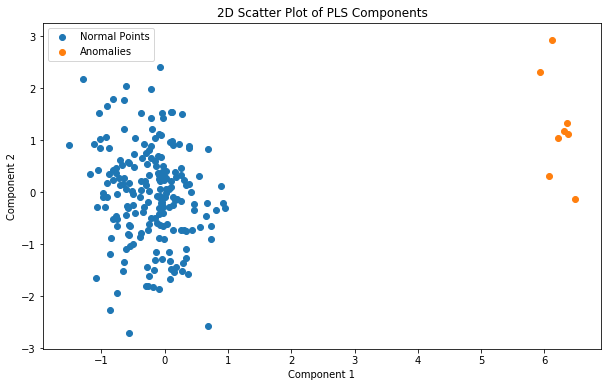

In [225]:
accuracy_score, Xtest_PLS, normal_points, anomalies = pls_iteration(2, 10)
plt.figure(figsize=(10, 6))
plt.scatter(Xtest_PLS[normal_points, 0], Xtest_PLS[normal_points, 1], label="Normal Points")
plt.scatter(Xtest_PLS[anomalies, 0], Xtest_PLS[anomalies, 1], label="Anomalies")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("2D Scatter Plot of PLS Components")
plt.legend()
plt.savefig("fig_4.1.02.png")
plt.show()

## Experiment using HSIC:

In [20]:
mu_array = np.linspace(0, 4, 10)

acc_2dims_array = np.zeros(mu_array.shape)
acc_3dims_array = np.zeros(mu_array.shape)

for k in range(5):
    for i, mu in enumerate(mu_array):
        acc_2dims = hsic_iteration(2, mu)[0]
        acc_3dims = hsic_iteration(3, mu)[0]
    
        acc_2dims_array[i] += acc_2dims
        acc_3dims_array[i] += acc_3dims
        
acc_2dims_array /= 100
acc_3dims_array /= 100

Compiling cost function...
Computing gradient of cost function...
 iter		   cost val	    grad. norm
    1	-2.8383093828203979e+11	2.74218132e+09
    2	-2.8556108101350574e+11	1.87988168e+09
    3	-2.8602371389338312e+11	1.80620036e+09
    4	-2.8621097182288025e+11	1.32668932e+09
    5	-2.8632991142892932e+11	6.43744237e+08
    6	-2.8634294947302704e+11	6.63933308e+08
    7	-2.8637394244567993e+11	1.92955251e+08
    8	-2.8637878843985736e+11	4.32529045e+08
    9	-2.8639140066170660e+11	1.47450786e+08
   10	-2.8639380433088037e+11	1.45973883e+08
   11	-2.8639614343962573e+11	1.10600940e+08
   12	-2.8639820686794763e+11	1.49247840e+08
   13	-2.8639882649510059e+11	2.26985451e+08
   14	-2.8640092488106677e+11	1.59823464e+08
   15	-2.8640195075231262e+11	2.11426247e+08
   16	-2.8640487125711121e+11	1.04196073e+08
   17	-2.8640666688960352e+11	2.01445697e+08
   18	-2.8640996977948242e+11	1.03225385e+08
   19	-2.8641154829485028e+11	2.34734816e+08
   20	-2.8641546761693854e+11	9.04127631e+07


KeyboardInterrupt: 

# Twitter Dataset:

## Cleaning of Data:

In [ ]:
# Importing Data:
twitter_data_folder = "NAB/data/realTweets/"
ticker_names = ["AAPL", "AMZN", "CRM", "CVS", "FB", "GOOG", "IBM", "KO", "PFE", "UPS"]

full_data = {}
for ticker in ticker_names:
    full_data[ticker] = pd.read_csv(f"{twitter_data_folder}Twitter_volume_{ticker}.csv")